In [108]:
import torch
from torch.nn import functional as F 
import matplotlib.pyplot as plt
import random

In [109]:
# Fetch all names from the file
names = []
with open('names.txt') as file:
    for name in file.read().splitlines():
        names.append(name)
names[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [146]:
# Build vocab
chars = sorted(set(".".join(names)))

stoi = {ch: i for i,ch in enumerate(chars)}
itos = {i:ch for ch, i in stoi.items()}

stoi

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [148]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(names):
  X, Y = [], []
  for w in names:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

random.seed(42)
random.shuffle(names)
n1 = int(0.8*len(names))
n2 = int(0.9*len(names))

X_train, y_train = build_dataset(names[:n1])
X_dev, y_dev = build_dataset(names[n1:n2])
X_test, y_test = build_dataset(names[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [233]:
# init params
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(27, 10, generator=g)
W1 = torch.randn(30, 200, generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn(200, 27, generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

In [234]:
no_params = sum(p.nelement() for p in parameters)

no_params

11897

In [235]:
for p in parameters:
    p.requires_grad = True

In [236]:
# How to pick a better learning rate
lre = torch.linspace(-3, 0, 1000)
lrs = 10 ** lre

In [237]:
def forward(X, y):
    # input layer
    embedding = C[X].view(-1, 30)
    # hidden layer
    h = torch.tanh(embedding @ W1 +b1)
    # Output layer
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    
    return loss

def backward(loss):
    for p in parameters:
        p.grad = None
    loss.backward()

def update(i):
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

In [238]:
losses = []
for i in range(200000):
    ix = torch.randint(0, X_train.shape[0], (100,))
    loss = forward(X_train[ix], y_train[ix])
    losses.append(loss.log10().item())
    backward(loss)
    update(lr)

print(f"{losses[-1]}")

0.3414173424243927


In [239]:
# testing on whole training set
loss = forward(X_train, y_train)
loss

tensor(2.1454, grad_fn=<NllLossBackward0>)

In [240]:
# testing on whole dev set
loss = forward(X_dev, y_dev)
loss

tensor(2.1988, grad_fn=<NllLossBackward0>)

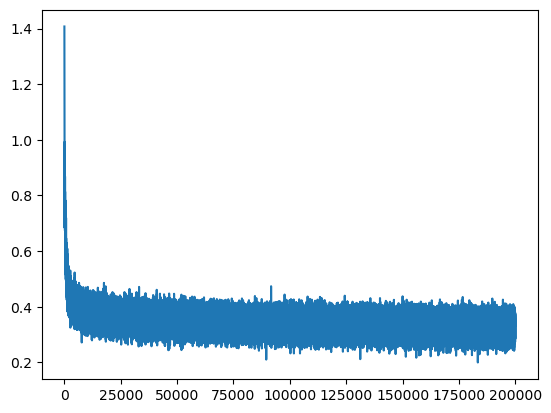

In [241]:
plt.plot(losses)

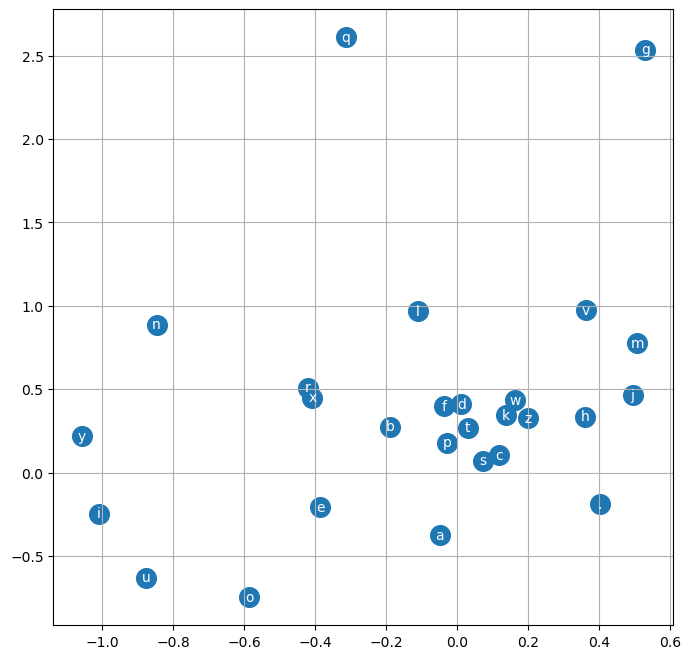

In [219]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')

In [242]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carpangaylyn.
kihaimrichelty.
skanden.
jazone.
fareyah.
pareei.
nekonia.
chaiir.
kaleigh.
ham.
prin.
quinn.
sulisen.
jaqui.
wayell.
dearynix.
khen.
dusabee.
deci.
abetteley.
